In [7]:
# Author: Gil Shulman
# Create Time: 2022-04-04

import ficc.utils.globals as globals
import os
import pickle
from google.cloud import bigquery
from ficc.utils.yield_curve import get_ficc_ycl
from ficc.utils.auxiliary_functions import sqltodf
from ficc.utils.auxiliary_functions import convert_dates
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "/Users/Gil/git/ficc/creds.json"

bq_client = bigquery.Client()

query = """ 
	SELECT
	cusip,trade_date,yield,calc_date,trade_type, par_traded, purpose_sub_class, coupon, maturity_date, sp_long
	FROM
	`eng-reactor-287421.auxiliary_views.materialized_trade_history`
	WHERE
	yield IS NOT NULL
	AND yield > 0
	-- AND par_traded >= 10000
	AND trade_date >= '2022-01-01'
	AND trade_date <= '2022-05-09'
	AND maturity_description_code = 2
	AND coupon_type in (8, 4, 10)
	AND capital_type <> 10
	AND default_exists <> TRUE
	AND sale_type <> 4
	AND sec_regulation IS NULL
	AND most_recent_default_event IS NULL
	AND default_indicator IS FALSE
	AND DATETIME_DIFF(trade_datetime,recent[SAFE_OFFSET(0)].trade_datetime,SECOND) < 1000000 -- 12 days to the most recent trade
	AND msrb_valid_to_date > current_date -- condition to remove cancelled trades
	ORDER BY
	trade_datetime DESC 
"""

In [8]:
'''Returns a `middle_percent` percent of data for `feature` centered at the median of that 
`feature`'s values. E.g., if `middle_percent == 50` and `feature == 'yield_spread'`, then 
this function returns all rows in `df` such that the `yield_spread` value is between the 
25th and 75th percentile.'''
def get_middle_percent(df, middle_percent, feature):
    assert 0 < middle_percent < 100
    assert middle_percent // 2 * 2 == middle_percent, '`middle_percent` must be divisible by 2 in order for the mask to work properly due to the integer typecasting'
    lower = (50 - middle_percent / 2) / 100
    upper = (50 + middle_percent / 2) / 100
    info = df[feature].describe(percentiles=sorted({lower, upper, 0.25, 0.5, 0.75}))
    print(info)
    mask = (df[feature] >= info[f'{int(lower * 100)}%']) & (df[feature] <= info[f'{int(upper * 100)}%'])
    return df[mask]

In [9]:
df = pd.read_pickle('ys_hist_trade_type.pkl')

#OR:

# df = sqltodf(query, bq_client)
# df['ficc_ycl'] = df.apply(lambda x: get_ficc_ycl(x, client=bq_client), axis=1)
# df['spread'] = df['yield'] * 100 - df.ficc_ycl
# df.to_pickle('ys_hist_trade_type.pkl')

In [10]:
# df['ficc_ycl'] = df.parallel_apply(lambda x: get_ficc_ycl(x, client=bq_client), axis=1)
# df['spread'] = df['yield'] * 100 - df.ficc_ycl
# df.to_pickle('ys_hist_trade_type.pkl')

In [26]:
print(f"{'{:,}'.format(len(df))} trades chosen from 2021-01-01 to 2022-05-09")

1,782,340 trades chosen from 2021-01-01 to 2022-05-09


In [12]:
from datetime import datetime

In [30]:
# True mid option ("true dealer dealer > 500K")
criteria_df = df[(df.coupon == 5) & (df.trade_type == 'D') & (df.par_traded >= 500000) &(df.trade_date > datetime.date(datetime.strptime('2022-01-01','%Y-%m-%d')))]
len(criteria_df)

12171

Suggestion: Make a plot where the x axis is time during April 2022, and the y axis is YS. For each cusip with large DD trades occurring on at least two different days, plot a separate line. This line is piecewise linear; it joins the observed YS for each trade in this cusip. All the lines together look like a sheaf. If the sheaf trends up or down, we are concerned.

In [31]:
#group by cusip: 
var_df = criteria_df.groupby(['cusip'])['spread'].agg(["mean", "median", "var","min","max","count"]).reset_index() 

print(f"{'{:,}'.format(len(var_df))} sample CUSIP traded between 2022-01-01 and 2022-05-09")

5,612 sample CUSIP traded between 2022-01-01 and 2022-05-09


In [32]:
var_df = var_df[(var_df['count'] > 1)]
print(f"{'{:,}'.format(len(var_df))} CUSIPs with more than 1 trade")

2,775 CUSIPs with more than 1 trade


In [33]:
print(f"{'{:,}'.format(len(var_df[var_df['max']-var_df['min'] != 0]))} CUSIPs where the yield spread has changed")
var_df['ys_max_min_delta'] = var_df['max']-var_df['min']

2,497 CUSIPs where the yield spread has changed


In [34]:
var_df = var_df[var_df.ys_max_min_delta != 0]

In [35]:
tdf = var_df.sort_values("ys_max_min_delta", ascending=False)

In [36]:
tdf.ys_max_min_delta.mean()


12.185684428481604

sum_spread_deltas/len(tdf): -4.765787301139771


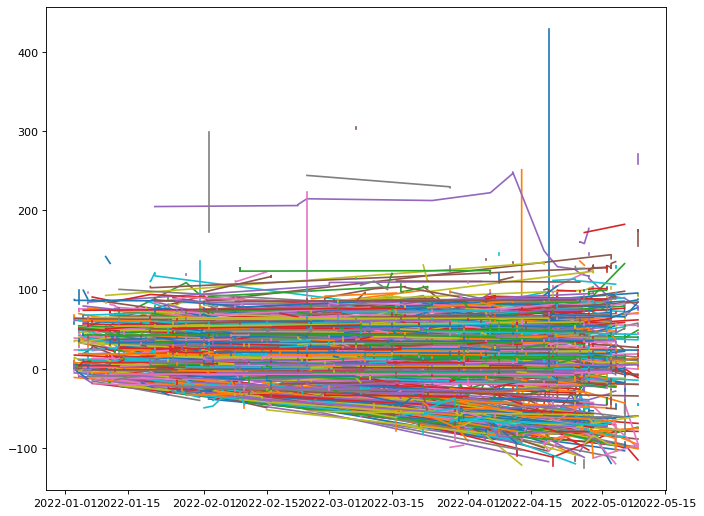

In [38]:
#plt.plot(<X AXIS VALUES HERE>, <Y AXIS VALUES HERE>, 'line type', label='label here')
figure(figsize=(10, 8), dpi=80)

sum_spread = 0

for index, row in tdf.iterrows(): # iterate on 1,002 5s CUSIPs where the yield spread has changed
    temp = criteria_df[criteria_df.cusip == row.cusip] # chose a single CUSIP
    sum_spread += (temp[temp.trade_date == temp.trade_date.max()].spread.mean() - temp[temp.trade_date == temp.trade_date.min()].spread.mean())
    plt.plot(temp.trade_date,temp.spread)
print(f"sum_spread_deltas/len(tdf): {sum_spread/len(tdf):}")
plt.show()

array([[<AxesSubplot:title={'center':'ys_max_min_delta'}>]], dtype=object)

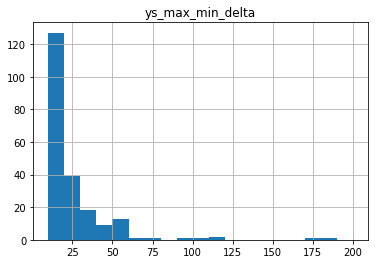

In [21]:
bins = [n+10 for n in range(200) if n % 10 == 0]
var_df.hist(column='ys_max_min_delta',bins=bins) # Limit to the top

In [22]:
var_df.head(30)

,cusip,mean,median,var,min,max,count,ys_max_min_delta
2,00037CVB3,-8.719254,-8.719254,32.000000,-12.719254,-4.719254,2,8.000000
9,010268AX8,5.274086,5.274086,0.980000,4.574086,5.974086,2,1.400000
11,010268CA6,11.450826,11.450826,11.319261,9.071828,13.829823,2,4.757995
14,010869GE9,-39.980564,-39.980564,62.720000,-45.580564,-34.380564,2,11.200000
15,011415RS7,55.836536,56.236536,0.480000,55.036536,56.236536,3,1.200000
18,01179RFA6,24.745562,24.745562,32.000000,20.745562,28.745562,2,8.000000
24,015303AY6,-9.223539,-9.223539,0.180000,-9.523539,-8.923539,2,0.600000
27,01757LEV4,-18.752630,-43.496309,6589.204720,-87.044482,99.026582,4,186.071064
32,02765ULT9,-9.993196,-24.613196,492.847000,-28.113196,14.286804,5,42.400000
34,02765URB2,35.349606,28.772470,144.078143,28.072470,49.203878,3,21.131408


In [23]:
var_df['stdev'] = var_df['var'].apply(np.sqrt)

In [24]:
var_df.stdev.agg('mean')

5.178337434597456

array([[<AxesSubplot:title={'center':'stdev'}>]], dtype=object)

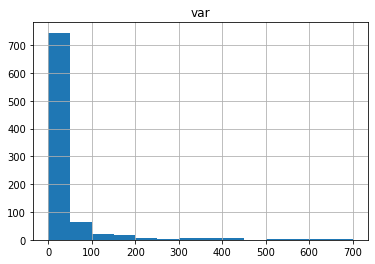

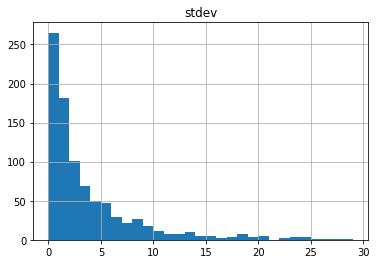

In [25]:
var_df['stdev'] = var_df['var'].apply(np.sqrt)
#var_df = var_df[var_df['var'] <= 1500]
#var_df['stdev'].value_counts(bins=2)
var_df[var_df['max']-var_df['min'] != 0]
#var_df[:1000].hist(column='var',bins=10)
bins = [n for n in range(750) if n % 50 == 0]
var_df.hist(column='var',bins=bins)
bins = [n for n in range(30)] 
var_df.hist(column='stdev',bins=bins)